In [1]:
from PIL import Image

# Load the image
image_path = "/content/drive/MyDrive/insulatos_model/Normal_Insulators/images/0049.jpg"
image = Image.open(image_path)


# Get the size (width and height) of the image
width, height = image.size

# Print the size
print("Image width:", width)
print("Image height:", height)


Image width: 1152
Image height: 864


In [2]:
import torch
from torchvision import transforms
from PIL import Image
import xml.etree.ElementTree as ET
import os

# Define the preprocessing transformations
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Preprocess a single image and its corresponding target annotations
def preprocess_data(image_file, xml_file, label_map):
    # Load the image
    image = Image.open(image_file)

    # Resize the image
    image = image.resize((1152, 864))

    # Convert the image to tensor and apply normalization
    image = preprocess(image)

    # Parse XML and get image and annotation information
    image_path, image_width, image_height, boxes, labels = parse_xml(xml_file)

    # Convert the bounding box coordinates to the format [xmin, ymin, xmax, ymax]
    boxes = [[box[0], box[1], box[0] + box[2], box[1] + box[3]] for box in boxes]

    # Convert the lists to tensors
    boxes = torch.FloatTensor(boxes)
    labels = [label_map[label] for label in labels]  # Map string labels to integer labels
    labels = torch.LongTensor(labels)

    return image, boxes, labels

# XML parsing function
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_path = root.find('path').text
    image_width = int(root.find('size/width').text)
    image_height = int(root.find('size/height').text)

    boxes = []
    labels = []

    for obj in root.findall('object'):
        label = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)

    return image_path, image_width, image_height, boxes, labels

# Set the paths to the folders containing the images and XML files
image_folder = "/content/drive/MyDrive/insulatos_model/Normal_Insulators/images"
xml_folder = "/content/drive/MyDrive/insulatos_model/Normal_Insulators/labels"

# Define the label mapping (string labels to integer labels)
label_map = {"insulator": 0, "label1": 1, "label2": 2, "label3": 3}

# Get the list of image files and XML files
image_files = os.listdir(image_folder)
xml_files = os.listdir(xml_folder)

# Process each image and its corresponding XML file
for xml_file in xml_files:
    # Get the corresponding image file name
    image_file = os.path.splitext(xml_file)[0] + ".jpg"
    image_path = os.path.join(image_folder, image_file)
    xml_path = os.path.join(xml_folder, xml_file)



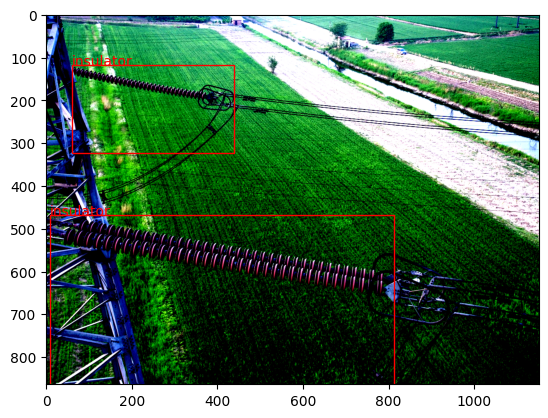

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Preprocess the image and get bounding box information
image_path = "/content/drive/MyDrive/insulatos_model/Normal_Insulators/images/0097.jpg"
xml_file = "/content/drive/MyDrive/insulatos_model/Normal_Insulators/labels/0097.xml"
image, boxes, labels = preprocess_data(image_path, xml_file, label_map)

# Display the image with bounding boxes
def show_image_with_boxes(image, boxes, labels, label_map):
    # Create a figure and axis
    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1, 2, 0))  # Convert tensor to the format (H, W, C)

    # Loop through each bounding box and label
    for box, label_id in zip(boxes, labels):
        label = list(label_map.keys())[list(label_map.values()).index(label_id)]

        # Extract coordinates
        xmin, ymin, xmax, ymax = box

        # Create a rectangle patch
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')

        # Add the rectangle patch to the axis
        ax.add_patch(rect)

        # Add label text near the bounding box
        ax.text(xmin, ymin, f"{label}", color='r')

    # Show the image with bounding boxes
    plt.show()

# Call the function to display the image with bounding boxes
show_image_with_boxes(image, boxes, labels, label_map)


In [4]:
import torchvision
from torch.utils.data import DataLoader

# Define the dataset class
class InsulatorDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, xml_folder, label_map, preprocess):
        self.image_folder = image_folder
        self.xml_folder = xml_folder
        self.label_map = label_map
        self.preprocess = preprocess

        self.image_files = os.listdir(image_folder)
        self.xml_files = os.listdir(xml_folder)

    def __getitem__(self, index):
        xml_file = self.xml_files[index]
        image_file = os.path.splitext(xml_file)[0] + ".jpg"
        image_path = os.path.join(self.image_folder, image_file)
        xml_path = os.path.join(self.xml_folder, xml_file)

        image_tensor, target_boxes, target_labels = preprocess_data(image_path, xml_path, self.label_map)

        # Wrap target boxes and labels into a dictionary
        target = {}
        target["boxes"] = target_boxes
        target["labels"] = target_labels

        return image_tensor, target

    def __len__(self):
        return len(self.xml_files)

# Create the dataset
dataset = InsulatorDataset(image_folder, xml_folder, label_map, preprocess)

# Set the training parameters
batch_size = 8
num_epochs = 20
learning_rate = 0.001

def collate_fn(batch):
    images, targets = zip(*batch)
    return images, targets




In [5]:
import torch
from torch.utils.data import random_split

# Split the dataset into training and testing subsets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # Remaining 20% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders for training and testing
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

# Instantiate the Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. Yo

In [6]:
# # Print the state dictionary to show the pre-trained weights
# print(model.state_dict())

In [7]:
# Access the classifier head's weights
classifier_weights = model.roi_heads.box_predictor.cls_score.weight
print(classifier_weights)

Parameter containing:
tensor([[-2.7376e-02,  6.4732e-03,  2.3470e-02,  ..., -2.1789e-01,
         -4.0838e-04,  3.8212e-02],
        [ 3.0750e-03,  5.5790e-03,  1.6688e-02,  ...,  7.8286e-02,
          2.0355e-02,  2.5957e-02],
        [ 2.9271e-02, -8.1584e-03,  1.7567e-02,  ..., -7.2571e-04,
          3.5533e-03,  1.1420e-02],
        ...,
        [-9.0817e-03, -2.5797e-02, -5.7688e-06,  ...,  8.4747e-03,
         -1.9983e-02, -7.0208e-02],
        [-5.9014e-03, -2.3718e-02, -6.2802e-04,  ...,  2.9037e-03,
         -4.7638e-03, -2.3198e-02],
        [ 1.0416e-02, -9.1762e-03, -4.3287e-04,  ..., -5.9320e-03,
          1.3853e-02, -2.6909e-02]], requires_grad=True)


In [8]:
# Replace the number of output classes in the model's classifier with the number of insulator classes
num_classes = len(label_map)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Define the optimizer and the learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [9]:
for images, targets in train_data_loader:
    # Print the first image and its targets
    print("Sample Image Tensor:")
    print(images[0])  # Print the first image in the batch

    print("Sample Targets (Annotations):")
    print(targets[0])  # Print the annotations (targets) for the first image in the batch
    break  # Break after printing the first batch for demonstration purposes

Sample Image Tensor:
tensor([[[ 0.8447,  0.9817,  1.1529,  ...,  0.2111,  0.2624,  0.1939],
         [ 0.6392,  0.3994,  0.3309,  ...,  0.2282,  0.2796, -0.1828],
         [ 1.4269,  1.3070,  0.9303,  ...,  0.2453,  0.1939, -0.0972],
         ...,
         [ 0.5193,  0.4508,  0.3481,  ..., -0.1143, -0.1828, -0.3883],
         [ 0.2967,  0.2453,  0.3138,  ..., -0.3541, -0.3712, -0.1657],
         [ 0.2282,  0.2796,  0.3652,  ..., -0.2171, -0.3541, -0.1486]],

        [[ 0.8529,  0.9930,  1.1681,  ...,  0.3978,  0.4503,  0.3803],
         [ 0.6078,  0.3627,  0.3277,  ...,  0.4153,  0.4678, -0.0049],
         [ 1.3606,  1.2381,  0.9055,  ...,  0.3978,  0.3803,  0.0826],
         ...,
         [ 0.5378,  0.4678,  0.3627,  ...,  0.2227,  0.1527, -0.0399],
         [ 0.2752,  0.2227,  0.3277,  ..., -0.0224, -0.0749,  0.1001],
         [ 0.2052,  0.2577,  0.3803,  ...,  0.1352, -0.0924,  0.0651]],

        [[ 0.8797,  1.0191,  1.1934,  ...,  0.2871,  0.3393,  0.2696],
         [ 0.6531,  0.40

Sample Image Tensor:
tensor([[[ 0.2967,  0.2796,  0.2624,  ...,  0.4337,  0.5022,  0.4508],
         [ 0.2796,  0.2796,  0.2624,  ...,  0.5193,  0.5536,  0.4851],
         [ 0.2111,  0.2282,  0.2282,  ...,  0.4851,  0.4851,  0.4508],
         ...,
         [-0.7650, -0.9363, -1.1932,  ..., -0.1657, -0.1486, -0.4054],
         [-0.9534, -1.0219, -1.0219,  ..., -0.2171, -0.1999, -0.3541],
         [-1.0048, -0.9877, -1.1247,  ..., -0.2171, -0.0458, -0.1143]],

        [[ 0.7304,  0.7129,  0.6954,  ...,  0.5028,  0.6254,  0.5728],
         [ 0.7129,  0.7129,  0.6954,  ...,  0.6429,  0.7129,  0.6429],
         [ 0.6779,  0.6954,  0.6954,  ...,  0.6429,  0.6604,  0.6254],
         ...,
         [-0.2150, -0.4426, -0.6877,  ...,  0.0826,  0.0476, -0.2150],
         [-0.4076, -0.5301, -0.5476,  ..., -0.0224, -0.0049, -0.2150],
         [-0.4601, -0.4951, -0.6527,  ..., -0.0224,  0.1001,  0.0301]],

        [[ 0.6356,  0.6182,  0.6008,  ...,  0.6705,  0.7751,  0.7228],
         [ 0.6182,  0.61

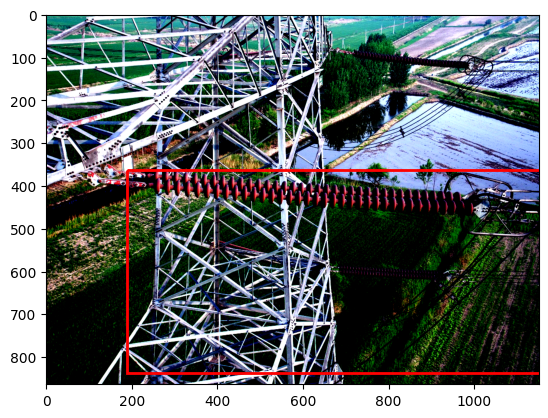

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

for images, targets in train_data_loader:
    # Print the first image and its targets
    print("Sample Image Tensor:")
    print(images[0])  # Print the first image in the batch

    print("Sample Targets (Annotations):")
    print(targets[0])  # Print the annotations (targets) for the first image in the batch

    # Convert the tensor to a numpy array
    image_np = images[0].permute(1, 2, 0).numpy()

    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image_np)

    # Get the bounding box coordinates
    bbox = targets[0]['boxes'][0]  # Assuming there is at least one bounding box in targets[0]

    # Create a Rectangle patch for the bounding box
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='r', facecolor='none')
    # Add the bounding box to the plot
    ax.add_patch(rect)
    # Show the plot
    plt.show()
    break  # Break after printing the first batch for demonstration purposes

In [11]:
# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, targets in train_data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    # Update the learning rate
    lr_scheduler.step()

    # Print the epoch loss
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_data_loader)}")



Epoch 1/20, Loss: 0.15343008612593015
Epoch 2/20, Loss: 0.06668848488479853
Epoch 3/20, Loss: 0.061084446217864755
Epoch 4/20, Loss: 0.04970934797699253
Epoch 5/20, Loss: 0.04622177615140875
Epoch 6/20, Loss: 0.0456607298925519
Epoch 7/20, Loss: 0.044498732623954616
Epoch 8/20, Loss: 0.0437220332523187
Epoch 9/20, Loss: 0.04387675269196431
Epoch 10/20, Loss: 0.04389904752994577
Epoch 11/20, Loss: 0.04315861631184816
Epoch 12/20, Loss: 0.0431700572061042
Epoch 13/20, Loss: 0.043599951267242434
Epoch 14/20, Loss: 0.04403933559854825
Epoch 15/20, Loss: 0.04401626434798042
Epoch 16/20, Loss: 0.044076108404745656
Epoch 17/20, Loss: 0.04281082479283214
Epoch 18/20, Loss: 0.04349590682735046
Epoch 19/20, Loss: 0.04265159855907162
Epoch 20/20, Loss: 0.04303104517360528


In [19]:
# Print the state dictionary to show the trained weights
print(model.state_dict())

OrderedDict([('backbone.body.conv1.weight', tensor([[[[ 1.3335e-02,  1.4664e-02, -1.5351e-02,  ..., -4.0896e-02,
           -4.3034e-02, -7.0755e-02],
          [ 4.1205e-03,  5.8477e-03,  1.4948e-02,  ...,  2.2060e-03,
           -2.0912e-02, -3.8517e-02],
          [ 2.2331e-02,  2.3595e-02,  1.6120e-02,  ...,  1.0281e-01,
            6.2641e-02,  5.1977e-02],
          ...,
          [-9.0349e-04,  2.7767e-02, -1.0105e-02,  ..., -1.2722e-01,
           -7.6604e-02,  7.8453e-03],
          [ 3.5894e-03,  4.8006e-02,  6.2051e-02,  ...,  2.4267e-02,
           -3.3662e-02, -1.5709e-02],
          [-8.0029e-02, -3.2238e-02, -1.7808e-02,  ...,  3.5359e-02,
            2.2439e-02,  1.7077e-03]],

         [[-1.8452e-02,  1.1415e-02,  2.3850e-02,  ...,  5.3736e-02,
            4.4022e-02, -9.4675e-03],
          [-7.7273e-03,  1.8890e-02,  6.7981e-02,  ...,  1.5956e-01,
            1.4606e-01,  1.1999e-01],
          [-4.6013e-02, -7.6075e-02, -8.9648e-02,  ...,  1.2108e-01,
            1.

In [20]:
# Access the classifier head's weights after training
classifier_weights = model.roi_heads.box_predictor.cls_score.weight
print(classifier_weights)

Parameter containing:
tensor([[-0.0213,  0.0130,  0.0054,  ...,  0.0350,  0.0065, -0.0071],
        [-0.0151, -0.0141, -0.0152,  ..., -0.0105, -0.0169, -0.0209],
        [-0.0367, -0.0058, -0.0102,  ..., -0.0335, -0.0301, -0.0286],
        [ 0.0021, -0.0208,  0.0166,  ..., -0.0070,  0.0041,  0.0244]],
       device='cuda:0', requires_grad=True)


In [21]:
# Save the trained model
torch.save(model.state_dict(), "insulator_detection_model.pth")

In [22]:
# # Load the trained model weights
# model.load_state_dict(torch.load("/content/insulator_detection_model.pth"))

# # Move the model to the GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# Set the model in evaluation mode
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [23]:
def perform_inference(image_path, model, label_map):
    # Load the image
    image = Image.open(image_path)

    # Preprocess the image
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        predictions = model(image_tensor)

    # Extract the predicted bounding boxes, labels, and scores
    boxes = predictions[0]['boxes'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()

    # Display the image with bounding boxes
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Loop through each prediction and plot the bounding box
    for box, label, score in zip(boxes, labels, scores):
        label_name = list(label_map.keys())[list(label_map.values()).index(label)]
        if score > 0.5:  # Set a threshold for the confidence score
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin, f"{label_name}: {score:.2f}", color='r')

    # Show the image with bounding boxes
    plt.show()

In [27]:
def perform_inference(image_path, model, label_map):
    model = model.to(device)  # Ensure model is in the right device
    image = Image.open(image_path)
    image_tensor = preprocess(image).unsqueeze(0).to(device)  # Ensure input is in the right device
    with torch.no_grad():
        predictions = model(image_tensor)
    boxes = predictions[0]['boxes'].cpu().numpy()  # Move to cpu for further operations
    labels = predictions[0]['labels'].cpu().numpy()  # Move to cpu for further operations
    scores = predictions[0]['scores'].cpu().numpy()  # Move to cpu for further operations
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for box, label, score in zip(boxes, labels, scores):
        label_name = list(label_map.keys())[list(label_map.values()).index(label)]
        if score > 0.5:  # Set a threshold for the confidence score
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin, f"{label_name}: {score:.2f}", color='r')
    plt.show()

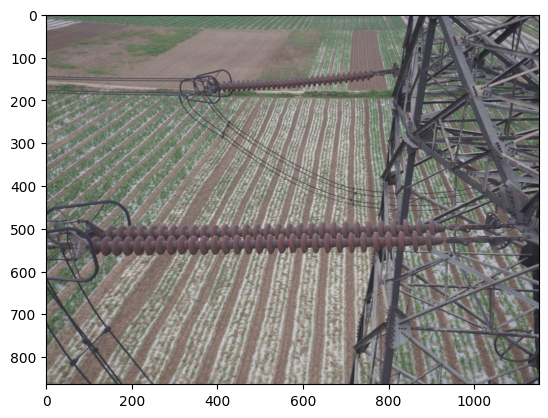

In [28]:
# Provide the path to the test image
test_image_path = "/content/drive/MyDrive/insulatos_model/Normal_Insulators/images/0051.jpg"

# Perform inference and display the results
perform_inference(test_image_path, model, label_map)

In [18]:
print(label_map)

{'insulator': 0, 'label1': 1, 'label2': 2, 'label3': 3}
